In [10]:
import pandas as pd
import ast
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

import pandas as pd

# Load the two datasets (replace 'ratings.csv' and 'wine_characteristics.csv' with your actual CSV file paths)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')
wine_data = pd.read_csv('Dataset/last/XWines_Slim_1K_wines.csv')
group_data = pd.read_csv('Dataset/last/group_composition.csv')  # Add path to your group CSV

# Merge the two datasets on 'WineID'
merged_data = pd.merge(ratings_data, wine_data, on='WineID')

# 1. Funktion: Extrahieren der Gruppendaten
def extract_group_members(group_df, group_id):
    """
    Extrahiert die Mitglieder einer Gruppe basierend auf der group_id.
    """
    group_row = group_df[group_df['group_id'] == group_id]
    if group_row.empty:
        print(f"Group ID {group_id} not found.")
        return None

    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Konvertiere String in Liste
    return group_members


# 2. Funktion: Filtern der Bewertungen für die Gruppenmitglieder
def get_group_ratings(group_members, ratings_df):
    """
    Gibt die Bewertungen der Gruppenmitglieder zurück.
    """
    return ratings_df[ratings_df['UserID'].isin(group_members)]


# 3. Funktion: Berechnung der Gruppenpräferenzen (Top-Kategorien)
def calculate_group_preferences(group_ratings, merged_data):
    """
    Berechnet die Top-Kategorien basierend auf den Präferenzen der Gruppenmitglieder.
    """
    # Gruppiere die Bewertungen nach WeinID und ermittel die Durchschnittsbewertung
    top_wines = group_ratings.groupby('WineID')['Rating'].mean().reset_index()
    
    # Mergiere mit den Weindaten, um die Merkmale zu erhalten
    wine_details = merged_data[merged_data['WineID'].isin(top_wines['WineID'])]
    
    # Berechne die Häufigkeit der Merkmale 'Type' und 'Body' in den top-bewerteten Weinen
    category_weights = {"Type": wine_details['Type'].value_counts().to_dict(),
                        "Body": wine_details['Body'].value_counts().to_dict()}
    
    return category_weights


# 4. Funktion: KNN-Modellierung für ähnliche Weine
def find_knn_recommendations(group_ratings, merged_data, k=10):
    """
    Berechnet ähnliche Weine basierend auf den Eigenschaften der Weine, die die Gruppe bewertet hat.
    """
    features = ['Type', 'Body']
    wine_features = merged_data[features]

    # One-Hot-Encoding der Merkmale
    encoder = OneHotEncoder(sparse_output=False)
    encoded_wine_features = encoder.fit_transform(wine_features)

    # KNN-Modell
    knn_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn_model.fit(encoded_wine_features)

    # Finde ähnliche Weine für jeden top-bewerteten Wein
    group_top_wines = group_ratings['WineID'].unique()
    similar_wines = []
    for wine_id in group_top_wines:
        target_wine = merged_data[merged_data['WineID'] == wine_id][features]
        if target_wine.empty:
            continue

        encoded_target_wine = encoder.transform(target_wine)
        distances, indices = knn_model.kneighbors(encoded_target_wine)

        # Speichere ähnliche Weine für diesen Wein
        similar_wines.append(merged_data.iloc[indices[0]][['WineID', 'Type', 'Body']])

    # Zusammenführen aller ähnlichen Weine
    similar_wines_df = pd.concat(similar_wines)
    return similar_wines_df.drop_duplicates()


# 5. Funktion: Auswahl des besten Weins basierend auf den Präferenzen
def get_best_wine_based_on_preferences(category_weights, merged_data):
    """
    Wählt den besten Wein basierend auf den Top-Kategorien.
    """
    # Sortiere nach den Top-Kategorien
    sorted_type = sorted(category_weights['Type'].items(), key=lambda x: x[1], reverse=True)[0][0]
    sorted_body = sorted(category_weights['Body'].items(), key=lambda x: x[1], reverse=True)[0][0]

    # Finde einen Wein mit diesen Eigenschaften
    best_wine = merged_data[(merged_data['Type'] == sorted_type) & (merged_data['Body'] == sorted_body)]
    
    if not best_wine.empty:
        return best_wine.sort_values(by='AvgRating', ascending=False).head(1)
    else:
        return None


# 6. Hauptfunktion: Gruppenempfehlung
def recommend_for_group(group_id, group_data, ratings_data, merged_data, k=10):
    """
    Hauptfunktion zur Generierung einer Gruppenempfehlung basierend auf group_id.
    """
    # Schritt 1: Extrahiere die Gruppenmitglieder
    group_members = extract_group_members(group_data, group_id)
    if not group_members:
        return "Gruppe nicht gefunden!"

    # Schritt 2: Filtere die Bewertungen der Gruppenmitglieder
    group_ratings = get_group_ratings(group_members, ratings_data)

    # Schritt 3: Berechne die Gruppenpräferenzen
    category_weights = calculate_group_preferences(group_ratings, merged_data)

    # Schritt 4: Berechne ähnliche Weine
    knn_recommendations = find_knn_recommendations(group_ratings, merged_data, k)

    # Schritt 5: Wähle den besten Wein basierend auf Präferenzen
    best_wine = get_best_wine_based_on_preferences(category_weights, merged_data)

    return {
        "Group Preferences": category_weights,
        "KNN Recommendations": knn_recommendations,
        "Best Wine Recommendation": best_wine
    }

# Beispiel für die Verwendung der Hauptfunktion:
# result = recommend_for_group(5, group_data, ratings_data, merged_data, k=10)
# print(result)


C:\Users\antoi\AppData\Local\Temp\ipykernel_33924\193419205.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')


In [11]:

# Load the ratings dataset (replace 'ratings.csv' with your actual file path)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')

# Group by 'user_id' and find the maximum rating for each user
user_max_ratings = ratings_data.groupby('UserID')['Rating'].max()

# Filter to get only users whose max rating was 3
users_with_max_rating_3 = user_max_ratings[user_max_ratings == 3].index

# Print the list of users whose maximum rating was 3
print("Users whose maximum rating was 3:")
print(users_with_max_rating_3)


Users whose maximum rating was 3:
Index([1006724, 1056257, 1145862, 1196247, 1197650, 1220278, 1245717, 1279250,
       1290651, 1316369, 1334222, 1380716, 1391592, 1393496, 1397551, 1400386,
       1406797, 1420747, 1558571, 1563515, 1664756, 1719976, 1760544, 1762859,
       1781649, 1816088, 1843929, 1936578, 1944444, 1977712, 1997980, 2061195],
      dtype='int64', name='UserID')


C:\Users\antoi\AppData\Local\Temp\ipykernel_33924\2936765225.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')


In [12]:
# create average rating for each wine

ratings = {}
for index, row in ratings_data.iterrows():
    if row['WineID'] not in ratings:
        ratings[row['WineID']] = {"total": row['Rating'], "count": 1}
    else:
        ratings[row['WineID']]["total"] += row['Rating']
        ratings[row['WineID']]["count"] += 1

# add the averages to the df
wine_data["AvgRating"] = 0.0

for index, row in wine_data.iterrows():
    wine_data.loc[index, "AvgRating"] = ratings[row["WineID"]]["total"]/ratings[row["WineID"]]["count"]

In [16]:
def recommend_for_group(group_id, group_data, ratings_data, merged_data, k=10, wine_id_only=False):
    """
    Hauptfunktion zur Generierung einer Gruppenempfehlung basierend auf group_id.

    Parameters:
    - group_id (int): ID der Gruppe, für die eine Empfehlung erstellt werden soll.
    - group_data (pd.DataFrame): DataFrame mit den Gruppendaten.
    - ratings_data (pd.DataFrame): DataFrame mit den Bewertungen.
    - merged_data (pd.DataFrame): DataFrame mit den Weinmerkmalen.
    - k (int): Anzahl der ähnlichen Weine, die im KNN verwendet werden (Standard: 10).
    - wine_id_only (bool): Wenn True, wird nur die WineID des besten Weins zurückgegeben. (Standard: False)

    Returns:
    - dict oder int: Wenn `wine_id_only` True ist, wird nur die WineID des besten Weins zurückgegeben. 
                     Andernfalls ein Dictionary mit den vollständigen Informationen.
    """
    # Schritt 1: Extrahiere die Gruppenmitglieder
    group_members = extract_group_members(group_data, group_id)
    if not group_members:
        return "Gruppe nicht gefunden!"

    # Schritt 2: Filtere die Bewertungen der Gruppenmitglieder
    group_ratings = get_group_ratings(group_members, ratings_data)

    # Schritt 3: Berechne die Gruppenpräferenzen
    category_weights = calculate_group_preferences(group_ratings, merged_data)

    # Schritt 4: Berechne ähnliche Weine
    knn_recommendations = find_knn_recommendations(group_ratings, merged_data, k)

    # Schritt 5: Wähle den besten Wein basierend auf Präferenzen
    best_wine = get_best_wine_based_on_preferences(category_weights, merged_data)

    # Wenn `wine_id_only` gesetzt ist, gib nur die WineID des besten Weins zurück
    if wine_id_only and best_wine is not None:
        return int(best_wine['WineID'].values[0])  # Gib die WineID als Integer zurück

    # Ansonsten die vollständigen Informationen zurückgeben
    return {
        "Group Preferences": category_weights,
        "KNN Recommendations": knn_recommendations,
        "Best Wine Recommendation": best_wine
    }



In [17]:
recommend_for_group(3,group_data,ratings_data,wine_data,wine_id_only=True)

180330

In [18]:
import pandas as pd
import ast  # Import to safely parse string representation of lists

def get_wines_rated_by_group(group_df, group_id, ratings_df, wine_id=None):
    """
    Get all wines rated by a specific group based on group_id, with optional filtering for a specific wine_id.

    Parameters:
    group_df (pd.DataFrame): DataFrame containing group data with columns like ['group_id', 'group_members'].
    group_id (int): The ID of the group to analyze.
    ratings_df (pd.DataFrame): DataFrame containing ratings data with columns ['UserID', 'WineID', 'Rating'].
    wine_id (int, optional): The ID of a specific wine to filter. Defaults to None.

    Returns:
    pd.DataFrame: DataFrame containing all wines rated by users in the specified group, optionally filtered by the given WineID.
    """
    # Step 1: Extract the group_members string using the group_id
    group_row = group_df[group_df['group_id'] == group_id]

    # Step 2: Check if group_members list is found
    if group_row.empty:
        print(f"Group ID {group_id} not found.")
        return pd.DataFrame(columns=['UserID', 'WineID', 'Rating'])
    
    # Step 3: Convert the group_members string into an actual list
    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Safely convert string to list
    
    # Step 4: Filter ratings_data for rows where UserID is in the group_members list
    filtered_ratings = ratings_df[ratings_df['UserID'].isin(group_members)]
    
    # Step 5: If wine_id is provided, filter further for that specific WineID
    if wine_id is not None:
        filtered_ratings = filtered_ratings[filtered_ratings['WineID'] == wine_id]

    # Step 6: Return the filtered DataFrame
    return filtered_ratings[['UserID', 'WineID', 'Rating']]

# Example Usage:
# Assuming you have `group_data` and `ratings_data` DataFrames defined
# result_df = get_wines_rated_by_group(group_data, 5, ratings_data, wine_id=111544)


In [19]:
for i in range(239):
    get_wines_rated_by_group(group_data,i,ratings_data,wine_id=recommend_for_group(i,group_data,ratings_data,wine_data,wine_id_only=True))

,UserID,WineID,Rating
5881,1078014,193478,4.5


In [20]:
recommend_for_group(0,group_data,ratings_data,wine_data,wine_id_only=True)

180330

In [21]:
group_data

,Unnamed: 0,group_id,group_size,group_similarity,group_members,avg_similarity
0,0,0,2,random,"[1110381, 1212243]",-0.006469
1,1,1,2,random,"[1180876, 1006585]",-0.015370
2,2,2,2,random,"[1174271, 1159745]",-0.015015
3,3,3,2,random,"[1223585, 1150327]",0.105930
4,4,4,2,random,"[1822155, 1138489]",0.163505
...,...,...,...,...,...,...
235,235,235,8,similar_one_divergent,"[1174766, 1226880, 1059478, 1062080, 1039599, ...",0.376073
236,236,236,8,similar_one_divergent,"[1203902, 1166271, 1078943, 2056705, 1204723, ...",0.400792
237,237,237,8,similar_one_divergent,"[1198066, 1041042, 1086821, 1293899, 1134438, ...",0.248949
238,238,238,8,similar_one_divergent,"[1908334, 1714244, 1018208, 1054770, 1642793, ...",0.361038


In [22]:
import pandas as pd
import numpy as np

def calculate_rmse(group_data, ratings_data, merged_data, k=10):
    """
    Berechnet den RMSE (Root Mean Squared Error) für alle Gruppenempfehlungen.

    Parameters:
    - group_data (pd.DataFrame): DataFrame mit den Gruppendaten.
    - ratings_data (pd.DataFrame): DataFrame mit den Bewertungen.
    - merged_data (pd.DataFrame): DataFrame mit den Weinmerkmalen.
    - k (int): Anzahl der ähnlichen Weine, die im KNN verwendet werden (Standard: 10).

    Returns:
    - float: RMSE für alle Gruppen.
    """
    squared_errors = []

    # Iteriere über alle group_id-Werte
    for group_id in range(group_data['group_id'].nunique()):
        try:
            # Schritt 1: Empfohlene WineID für die Gruppe berechnen
            recommended_wine_id = recommend_for_group(group_id, group_data, ratings_data, merged_data, k, wine_id_only=True)
            
            # Schritt 2: Hol die tatsächlichen Bewertungen für die empfohlene WineID in der Gruppe
            group_ratings = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=recommended_wine_id)

            # Schritt 3: Falls Bewertungen vorhanden sind, berechne den Fehler
            if not group_ratings.empty:
                # Beispiel: Angenommen, das Recommender-System sagt eine Bewertung von 4.0 voraus
                predicted_rating = 4.0  # Hier kannst du eine andere Logik zur Vorhersage der Bewertung einsetzen
                
                # Berechne den quadratischen Fehler für jede tatsächliche Bewertung
                for actual_rating in group_ratings['Rating']:
                    squared_error = (predicted_rating - actual_rating) ** 2
                    squared_errors.append(squared_error)
                    
        except Exception as e:
            print(f"Fehler bei group_id {group_id}: {e}")

    # Schritt 4: RMSE berechnen
    rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else None
    return rmse

# Beispiel-Aufruf (nachdem `group_data`, `ratings_data`, und `merged_data` definiert sind):
# rmse_value = calculate_rmse(group_data, ratings_data, merged_data)
# print(f"RMSE für die Gruppenempfehlungen: {rmse_value}")


In [23]:
rmse_value = calculate_rmse(group_data, ratings_data, wine_data)
print(f"RMSE für die Gruppenempfehlungen: {rmse_value}")

RMSE für die Gruppenempfehlungen: 0.8803408430829505


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Funktion zur Berechnung von Metriken und Erzeugung von Visualisierungen
def evaluate_recommender_system(group_data, ratings_data, merged_data, k=10, plot=True):
    """
    Bewertet das Gruppenempfehlungssystem und erstellt Visualisierungen.

    Parameters:
    - group_data (pd.DataFrame): DataFrame mit den Gruppendaten.
    - ratings_data (pd.DataFrame): DataFrame mit den Bewertungen.
    - merged_data (pd.DataFrame): DataFrame mit den Weinmerkmalen.
    - k (int): Anzahl der ähnlichen Weine, die im KNN verwendet werden (Standard: 10).
    - plot (bool): Ob Visualisierungen erstellt werden sollen (Standard: True).

    Returns:
    - dict: Enthält die berechneten Metriken (RMSE, MAE, R²).
    """
    true_ratings = []
    predicted_ratings = []

    # Iteriere über alle group_id-Werte
    for group_id in range(group_data['group_id'].nunique()):
        try:
            # Schritt 1: Empfohlene WineID für die Gruppe berechnen
            recommended_wine_id = recommend_for_group(group_id, group_data, ratings_data, merged_data, k, wine_id_only=True)
            
            # Schritt 2: Hol die tatsächlichen Bewertungen für die empfohlene WineID in der Gruppe
            group_ratings = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=recommended_wine_id)

            # Schritt 3: Falls Bewertungen vorhanden sind, speichere die tatsächlichen und die vorhergesagten Bewertungen
            if not group_ratings.empty:
                predicted_rating = 4.0  # Setze einen Beispiel-Wert für die Vorhersage (kann durch ein reales Modell ersetzt werden)
                
                for actual_rating in group_ratings['Rating']:
                    true_ratings.append(actual_rating)
                    predicted_ratings.append(predicted_rating)
                    
        except Exception as e:
            print(f"Fehler bei group_id {group_id}: {e}")

    # Schritt 4: Berechnung der Metriken
    rmse = np.sqrt(np.mean((np.array(true_ratings) - np.array(predicted_ratings)) ** 2))
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    r2 = r2_score(true_ratings, predicted_ratings)

    metrics = {
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

    # Schritt 5: Visualisierungen (optional)
    if plot:
        # Histogramm der Fehler
        errors = np.array(predicted_ratings) - np.array(true_ratings)
        plt.figure(figsize=(10, 5))
        plt.hist(errors, bins=20, color='skyblue')
        plt.title("Histogram of Prediction Errors (Predicted - Actual)")
        plt.xlabel("Prediction Error")
        plt.ylabel("Frequency")
        plt.grid()
        plt.show()

        # Scatterplot der tatsächlichen vs. vorhergesagten Bewertungen
        plt.figure(figsize=(8, 8))
        plt.scatter(true_ratings, predicted_ratings, alpha=0.6, color='orange')
        plt.plot([min(true_ratings), max(true_ratings)], [min(true_ratings), max(true_ratings)], color='blue', linestyle='--')
        plt.title("Actual vs. Predicted Ratings")
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.grid()
        plt.show()

    return metrics

# Beispiel-Aufruf (nachdem `group_data`, `ratings_data`, und `merged_data` definiert sind):
# metrics = evaluate_recommender_system(group_data, ratings_data, merged_data)
# print("Metrics:", metrics)


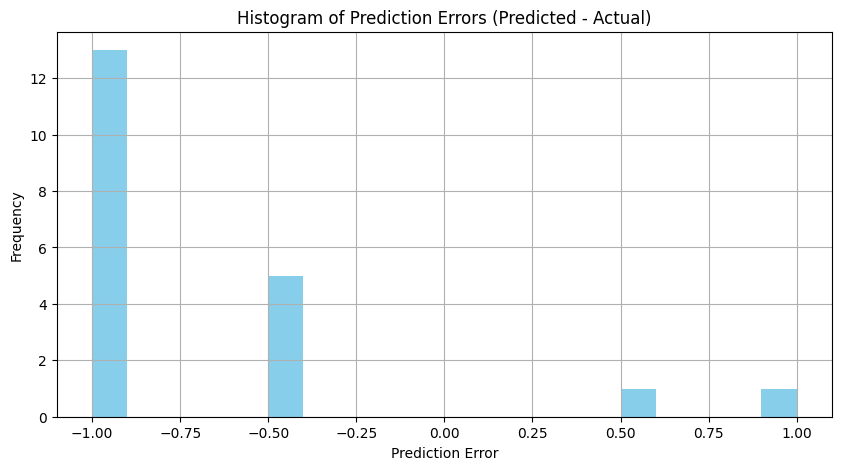

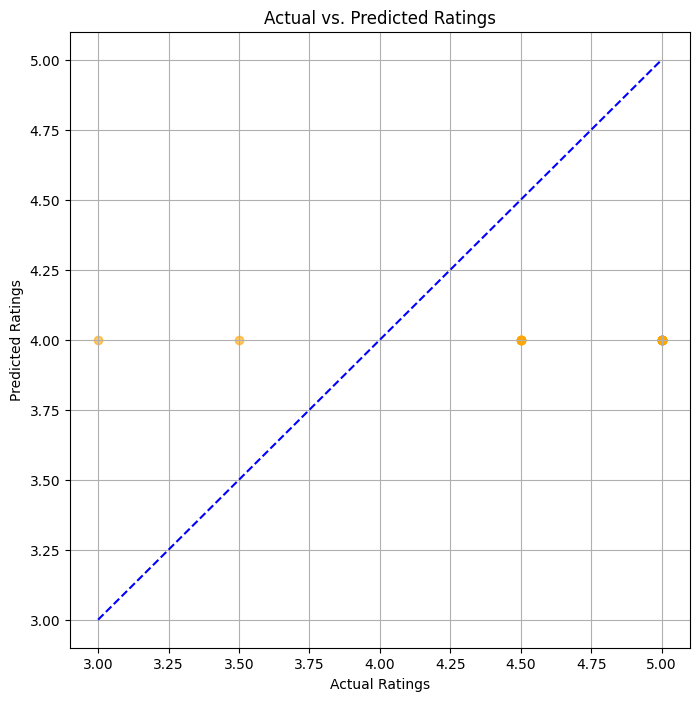

Metrics: {'RMSE': 0.8803408430829505, 'MAE': 0.85, 'R²': -1.7192982456140355}


In [25]:
metrics = evaluate_recommender_system(group_data, ratings_data, wine_data)
print("Metrics:", metrics)
